# MOVIE RATING PREDICTION

## Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import joblib
import xgboost as xgb

## Load Dataset

In [2]:
df = pd.read_csv("IMDb_Movies_India.csv", encoding='latin1')
df.head()
df.dropna(subset=['Rating'], inplace=True)
df['Duration'] = df['Duration'].str.extract(r'(\d+)').astype(float)
df['Year'] = pd.to_numeric(df['Year'].str.extract(r'(\d{4})')[0], errors='coerce')
df['Votes'] = df['Votes'].astype(str).str.replace(',', '', regex=False)
df['Votes'] = pd.to_numeric(df['Votes'], errors='coerce')

## Exploratory Data Analysis (EDA)

--- Exploratory Data Analysis (EDA) for Movie Ratings ---

1. Distribution of Movie Ratings


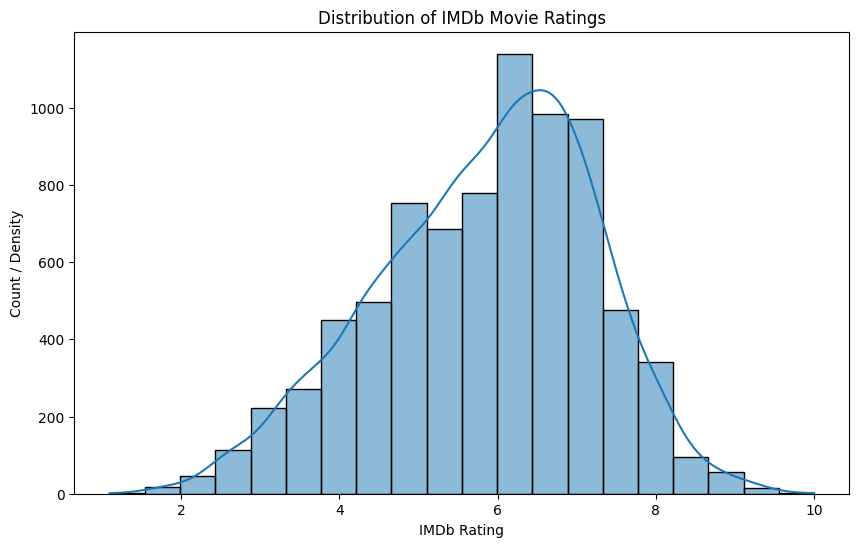


2. Correlation Heatmap


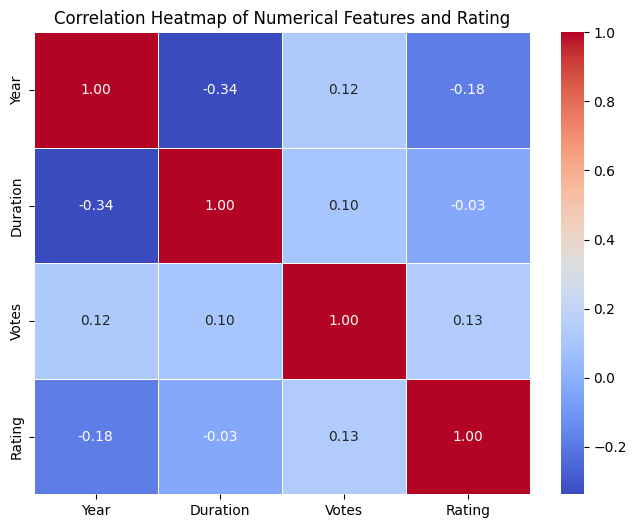


3. Movie Rating vs. Numerical Features


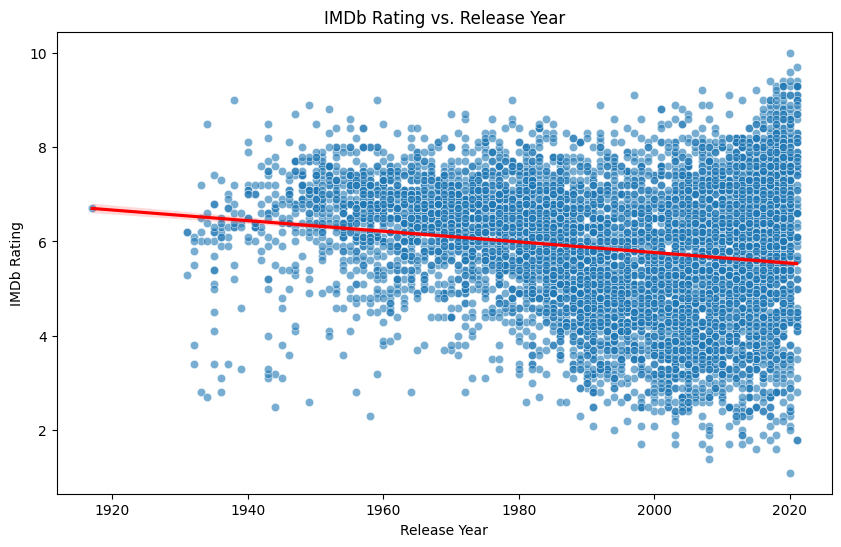

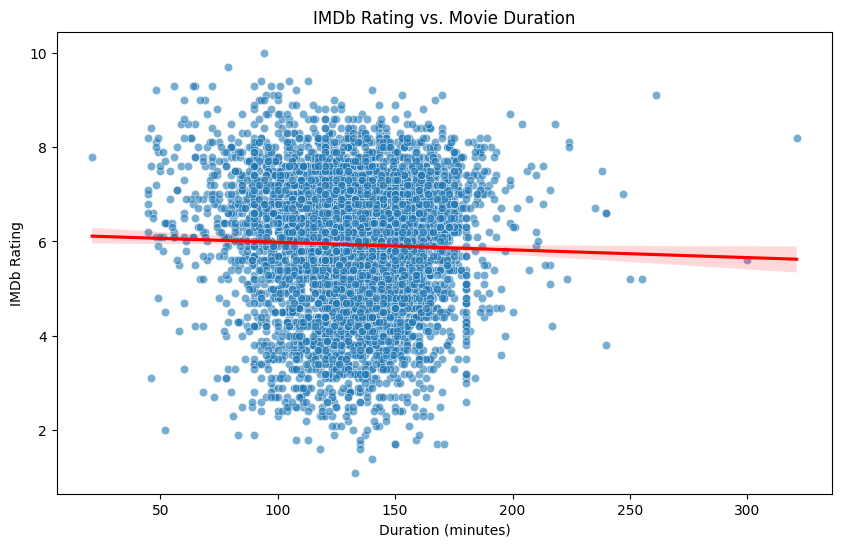

*(Note: 'Votes' is often highly skewed, so a log scale might be useful for visualization)*


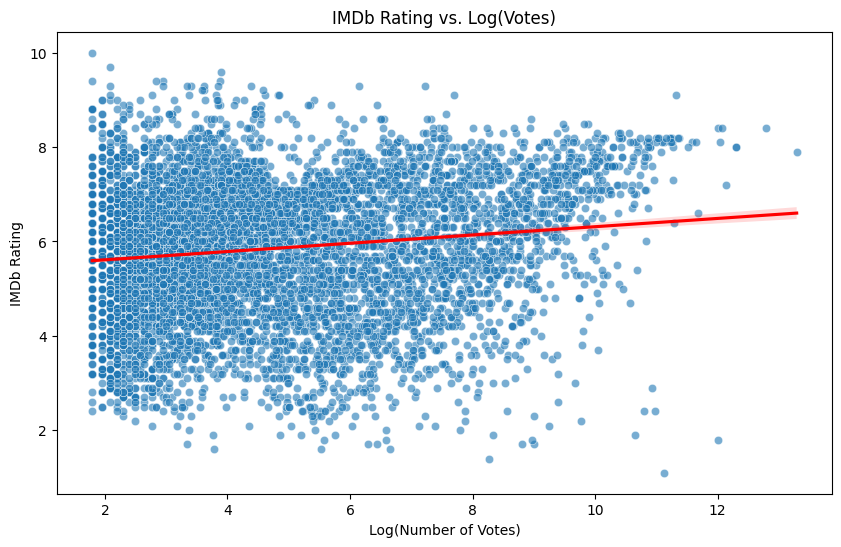


4. IMDb Rating Distribution by Top Genres


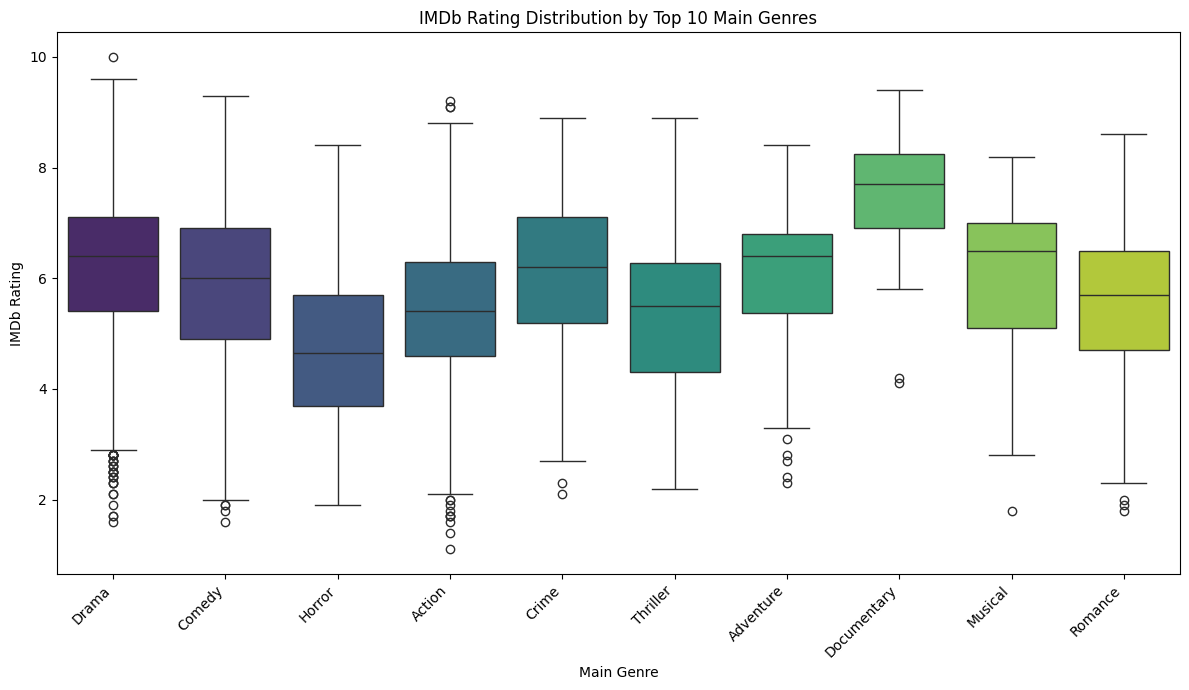


5. Average IMDb Rating by Top Directors


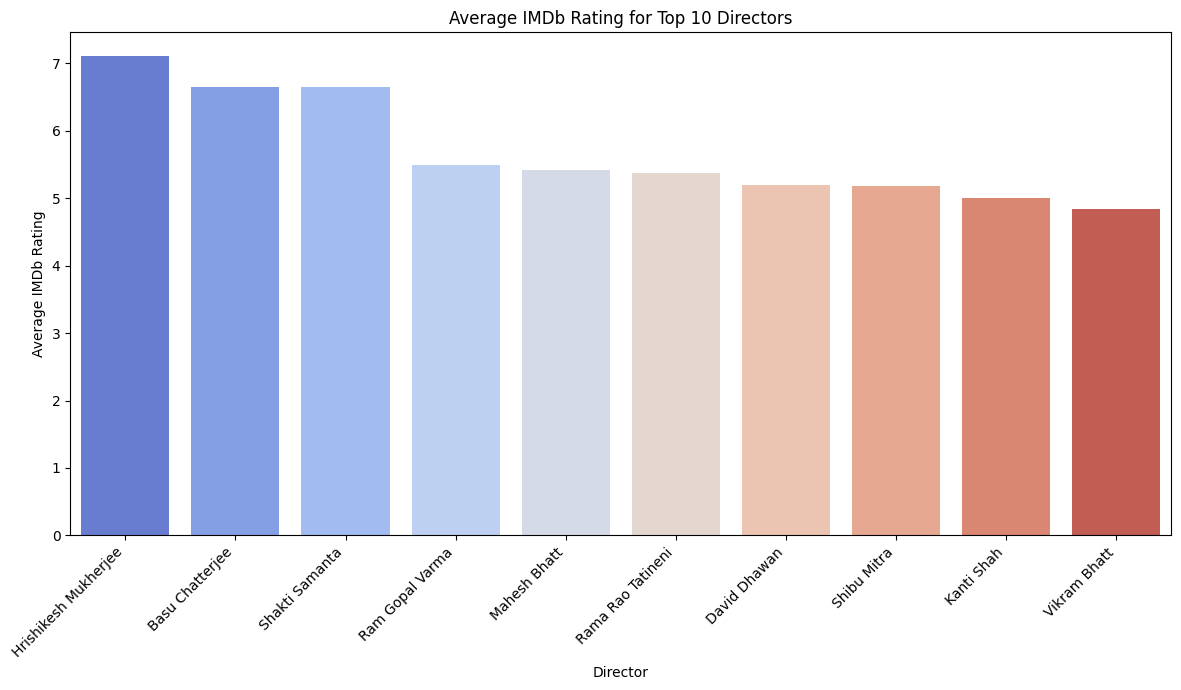

In [3]:
print("--- Exploratory Data Analysis (EDA) for Movie Ratings ---")

# 1. Distribution of Movie Ratings
print("\n1. Distribution of Movie Ratings")
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(df['Rating'], kde=True, ax=ax, bins=20)
ax.set_title('Distribution of IMDb Movie Ratings')
ax.set_xlabel('IMDb Rating')
ax.set_ylabel('Count / Density')
plt.show()

# 2. Correlation Heatmap
print("\n2. Correlation Heatmap")
numerical_cols_for_corr = ['Year', 'Duration', 'Votes', 'Rating']
corr_df = df[numerical_cols_for_corr].dropna()
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr_df.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, ax=ax)
ax.set_title('Correlation Heatmap of Numerical Features and Rating')
plt.show()

# 3. Rating vs. Numerical Features (Scatter Plots)
print("\n3. Movie Rating vs. Numerical Features")

# Rating vs. Year
fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x='Year', y='Rating', data=df, alpha=0.6, ax=ax)
sns.regplot(x='Year', y='Rating', data=df, scatter=False, color='red', ax=ax)
ax.set_title('IMDb Rating vs. Release Year')
ax.set_xlabel('Release Year')
ax.set_ylabel('IMDb Rating')
plt.show()

# Rating vs. Duration
fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x='Duration', y='Rating', data=df, alpha=0.6, ax=ax)
sns.regplot(x='Duration', y='Rating', data=df, scatter=False, color='red', ax=ax)
ax.set_title('IMDb Rating vs. Movie Duration')
ax.set_xlabel('Duration (minutes)')
ax.set_ylabel('IMDb Rating')
plt.show()

# Rating vs. Votes (log scale for better visualization if votes vary widely)
print("*(Note: 'Votes' is often highly skewed, so a log scale might be useful for visualization)*")
fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x=np.log1p(df['Votes']), y='Rating', data=df, alpha=0.6, ax=ax)
sns.regplot(x=np.log1p(df['Votes']), y='Rating', data=df, scatter=False, color='red', ax=ax)
ax.set_title('IMDb Rating vs. Log(Votes)')
ax.set_xlabel('Log(Number of Votes)')
ax.set_ylabel('IMDb Rating')
plt.show()

# 4. Rating Distribution by Top Genres (Box Plot)
print("\n4. IMDb Rating Distribution by Top Genres")
df_genres_split = df.copy()
df_genres_split['Main_Genre'] = df_genres_split['Genre'].apply(lambda x: str(x).split(',')[0].strip() if pd.notna(x) else 'Unknown')

top_genres = df_genres_split['Main_Genre'].value_counts().nlargest(10).index
df_top_genres = df_genres_split[df_genres_split['Main_Genre'].isin(top_genres)]

fig, ax = plt.subplots(figsize=(12, 7))
sns.boxplot(x='Main_Genre', y='Rating', data=df_top_genres, ax=ax, palette='viridis', hue='Main_Genre', legend=False)
ax.set_title('IMDb Rating Distribution by Top 10 Main Genres')
ax.set_xlabel('Main Genre')
ax.set_ylabel('IMDb Rating')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 5. Average Rating by Top Directors (Bar Plot)
print("\n5. Average IMDb Rating by Top Directors")
top_directors = df['Director'].value_counts().nlargest(10).index
df_top_directors = df[df['Director'].isin(top_directors)]

avg_ratings_by_director = df_top_directors.groupby('Director')['Rating'].mean().sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(12, 7))
sns.barplot(x=avg_ratings_by_director.index, y=avg_ratings_by_director.values, ax=ax, palette='coolwarm', hue=avg_ratings_by_director.index, legend=False)
ax.set_title('Average IMDb Rating for Top 10 Directors')
ax.set_xlabel('Director')
ax.set_ylabel('Average IMDb Rating')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Train-Test Split

In [4]:
features = ['Year', 'Duration', 'Genre', 'Votes', 'Director']
X = df[features]
y = df['Rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
numeric_features = ['Year', 'Duration', 'Votes']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_features = ['Genre', 'Director']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

## Preprocessing

In [6]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

## Model Definitions & Evaluations

In [7]:
# --- Model Definitions and Evaluation ---
models = {
    'Linear Regression': LinearRegression(),
    'KNN': KNeighborsRegressor(n_neighbors=5),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42)
}

print("\n--- Model Evaluation Results ---")

results = {}
for name, model in models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('model', model)])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results[name] = {'RMSE': rmse, 'R2': r2}
    print(f"{name}: RMSE = {rmse:.2f}, R2 = {r2:.2f}")


--- Model Evaluation Results ---
Linear Regression: RMSE = 1.37, R2 = -0.01
KNN: RMSE = 1.18, R2 = 0.25
Random Forest: RMSE = 1.11, R2 = 0.34
XGBoost: RMSE = 1.09, R2 = 0.36


## Save Final Model (XGBoost)

In [8]:
# Select the best model based on R2 score
best_model_name = max(results.items(), key=lambda x: x[1]['R2'])[0]
print(f"\nBest model: {best_model_name}")


Best model: XGBoost


## Select the best_model_pipeline

In [9]:
# Select the best_model_pipeline
best_model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                      ('model', xgb.XGBRegressor(n_estimators=100, random_state=42))])
best_model_pipeline.fit(X_train, y_train)

joblib.dump(best_model_pipeline, 'movie_rating_prediction_pipeline.pkl')
print("Movie rating prediction pipeline saved as 'movie_rating_prediction_pipeline.pkl'")

Movie rating prediction pipeline saved as 'movie_rating_prediction_pipeline.pkl'
